### Laboratory work 10 - Extended Kalman filter for navigation and tracking
#### Abramov Semen, Belikov Ilia, Nikolay Zherdev, Mikhail Kulbeda
#### Skoltech, 22.10.2018

The objective of this laboratory work is to develop Extended Kalman filter for tracking a moving object when measurements and motion model are in different coordinate systems. This will bring about a deeper understanding of main difficulties of practical Kalman filter implementation for nonlinear models.

In [76]:
import pandas as pd
import numpy as np
from math import pi
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from tqdm import tqdm_notebook as tqdm

from numpy import linalg as LA

init_notebook_mode(connected=True)

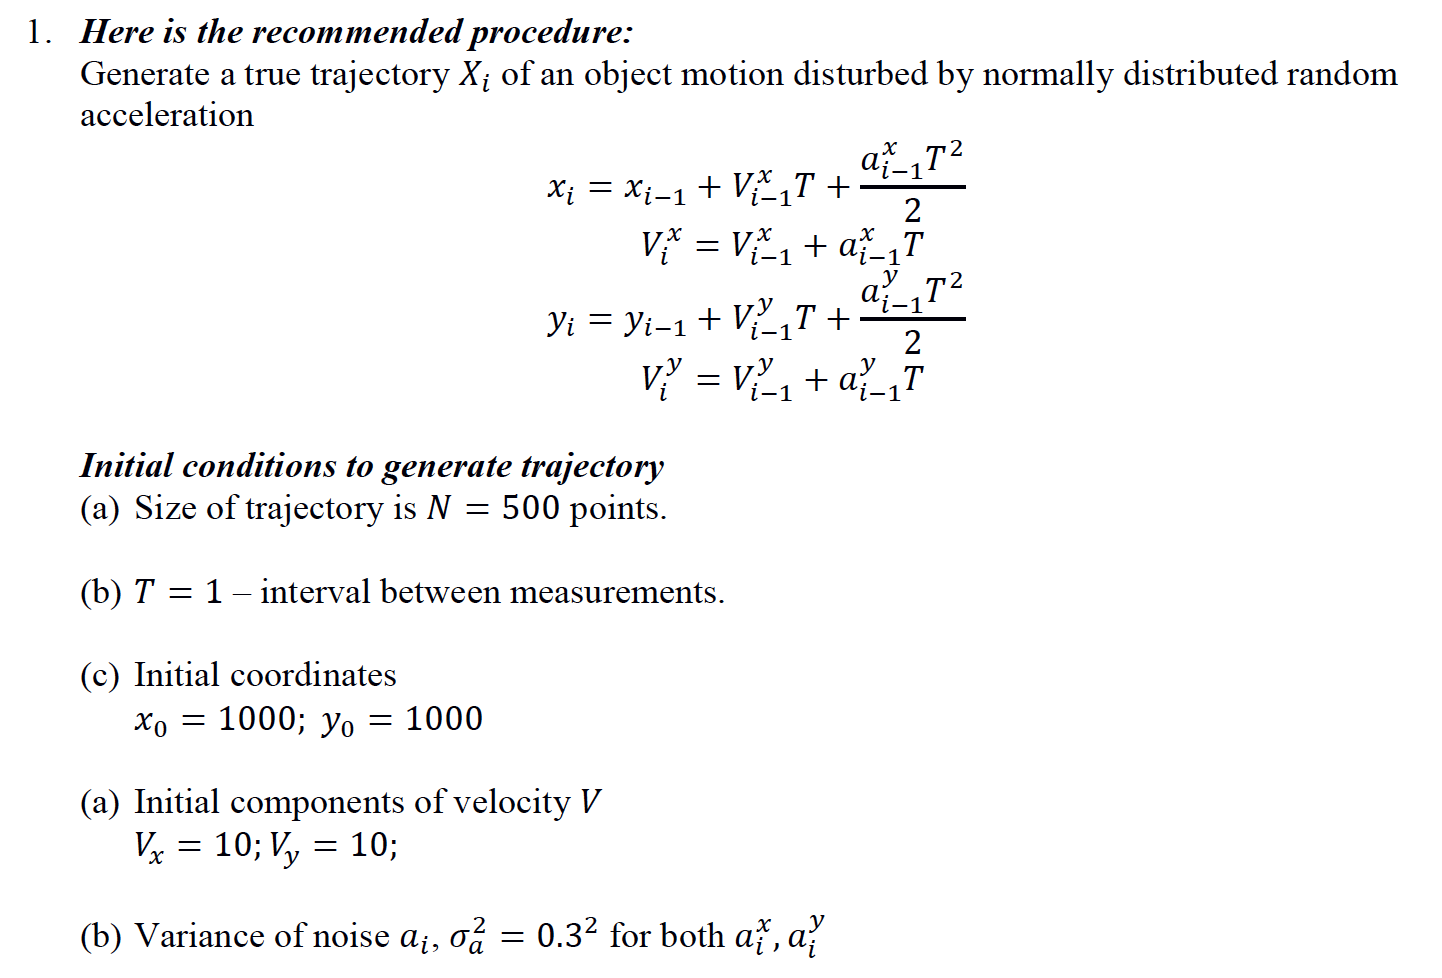

In [77]:
# Accelerated motion
def generate_trajectory(X0, V0, T = 1, N = 500, bias = 0, sigma_acc = 0.3):

    V = np.zeros((N, 2))
    X = np.zeros((N, 2))

    X[0] = X0
    V[0] = V0
    
    a = np.random.normal(loc=bias, scale=sigma_acc, size=(N,2))

    V[1:] = a[:-1]*T
    V = np.cumsum(V, axis=0)
    
    X[1:] = V[:-1]*T + a[:-1]*(T**2)/2
    X = np.cumsum(X, axis=0)
    
    S = np.zeros((N, 4))
    S[:,0] = X[:,0]
    S[:,1] = V[:,0]
    S[:,2] = X[:,1]
    S[:,3] = V[:,1]
    
    return X, V, S

In [78]:
X, V, S = generate_trajectory(X0=[1000, 1000], V0=[10, 10], T = 1, N = 500)

In [79]:
data = [
    go.Scatter(
        y=X[:,1],
        x=X[:,0],
        name='true x'
    ),
]

layout= go.Layout(
    title= 'Kalman filtration of gapped data',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

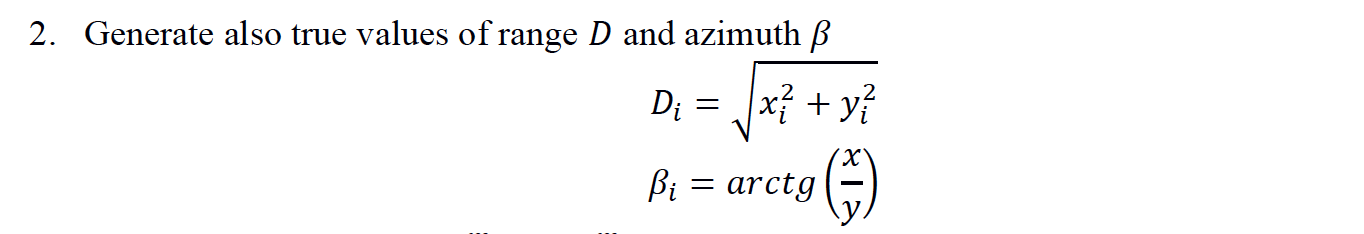

In [80]:
def generate_polar(X, Y, N):
        
    D = np.zeros((N))
    beta = np.zeros((N))
    
    D[:] = np.sqrt(X[:]**2 + Y[:]**2)
    beta[:] = np.arctan2(X[:], Y[:])
    
    return D, beta

In [81]:
trD, trbeta = generate_polar(X[:,0], X[:,1], N = 500)

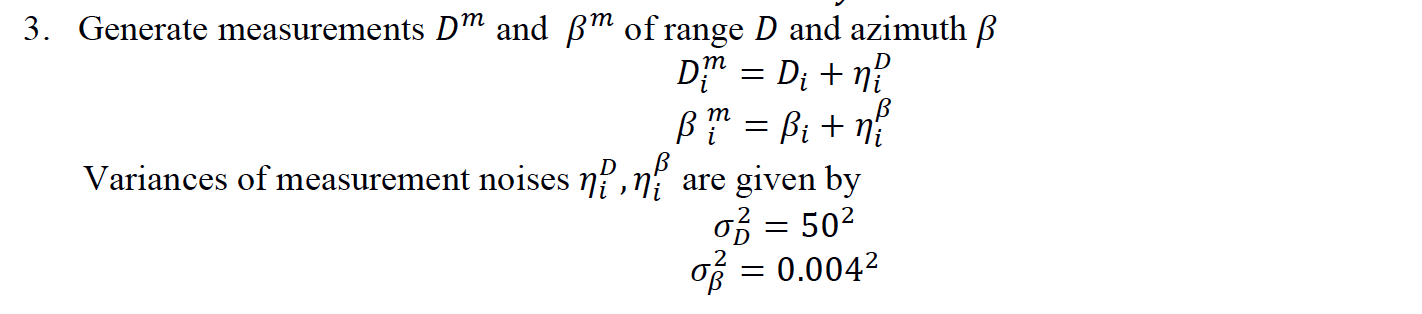

In [82]:
def measure(D, beta, N, sigma_D = 50, sigma_b = 0.004, mean = 0):
    
    msr_D = np.zeros((D.shape))
    msr_b = np.zeros((beta.shape))
    
    noise_D = np.random.normal(loc = mean, scale = sigma_D, size = N)
    noise_b = np.random.normal(loc = mean, scale = sigma_b, size = N)
    
    msr_D = D[:] + noise_D
    msr_b = beta[:] + noise_b

    return msr_D, msr_b

In [83]:
msr_D, msr_b = measure(trD, trbeta, N = 500)

In [84]:
z = np.column_stack((msr_D, msr_b))

In [85]:
msr_X = msr_D*np.sin(msr_b)
msr_Y = msr_D*np.cos(msr_b)

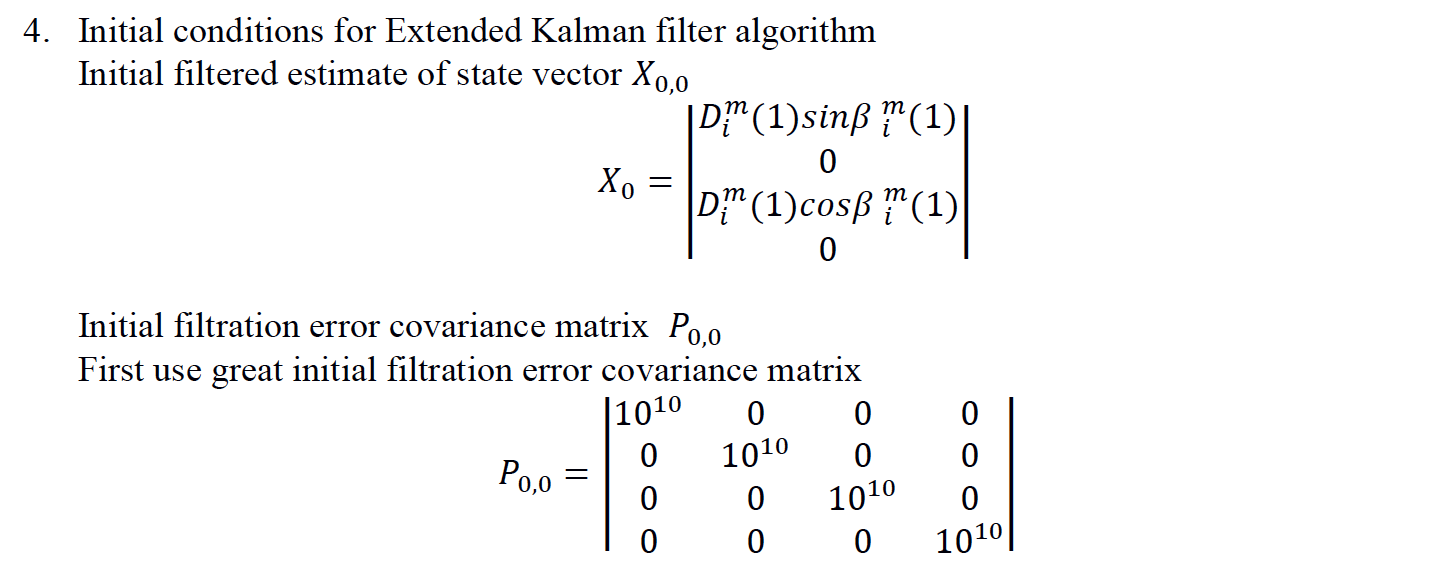

In [86]:
S0 = np.array((msr_D[0]*np.sin(msr_b[0]), 0, msr_D[0]*np.cos(msr_b[0]), 0))
P0 = np.eye(4)*(10**10)

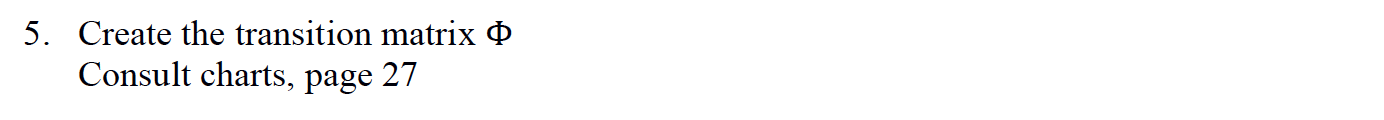

In [87]:
T = 1
F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
G = np.array([[(T**2)/2, 0], [T, 0], [0, (T**2)/2], [0, T]])

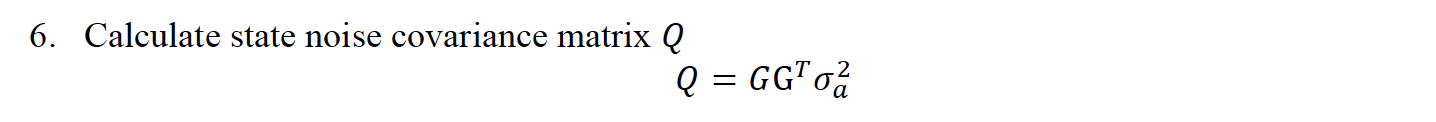

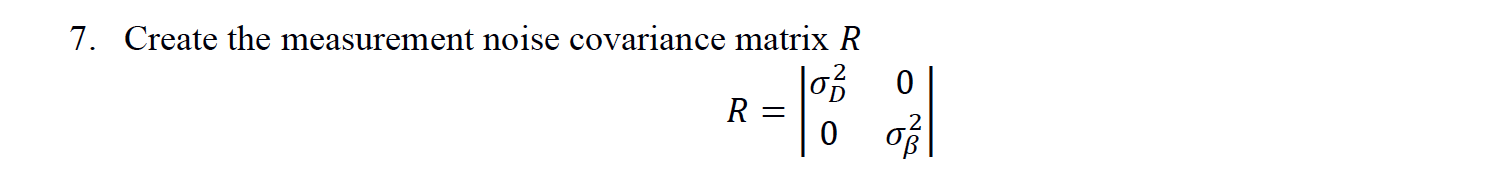

In [107]:
def H(X):
    return np.array([np.sqrt(X[0]**2 + X[2]**2), np.math.atan(X[0]/X[2])])

def kalman(msr, S0 = S0, P0 = P0, T=1, sigma_D = 50, sigma_b = 0.004, K=None, q=0):
    
    size = msr.shape
    
    F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
    G = np.array([[(T**2)/2, 0], [T, 0], [0, (T**2)/2], [0, T]])
    
    Q = G.dot(G.T)*0.3**2
    
    P = np.zeros((size[0], 4, 4))
    P_ = np.zeros((size[0], 4, 4))
    dH = np.zeros((size[0], 2, 4))
    
    D = np.zeros(len(msr)) # predicted 
    D_ = np.zeros(len(msr)) # filtered
    beta = np.zeros(len(msr)) # predicted 
    beta_ = np.zeros(len(msr)) # filtered
    
    R = np.array([[sigma_D**2, 0], [0, sigma_b**2]])
    
    K = np.zeros((size[0], 4, 2))
    
    # allocate space for arrays
    X=np.zeros((size[0], 4))
    X_=np.zeros((size[0], 4))
    
    # intial guesses
    X_[0] = S0
    P_[0] = P0
    
    for k in range(1, size[0]):
        # prediction
        X[k] = F.dot(X_[k-1])
        P[k] = F.dot(P_[k-1].dot(F.T)) + Q
        
        # polar predicted
        D[k] = np.sqrt(X[k][0]**2 + X[k][2]**2) # X and Y from state S0
        beta[k] = np.arctan2(X[k][0], X[k][2])
        
        dH = np.array([[X[k,0]/np.sqrt(X[k,0]**2 + X[k,2]**2), 0, X[k,2]/np.sqrt(X[k,0]**2 + X[k,2]**2), 0],
                      [X[k,2]/(X[k,0]**2 + X[k,2]**2), 0, -X[k,0]/(X[k,0]**2 + X[k,2]**2), 0]])
        
        msr[k,0]
        
        K[k] = P[k].dot(dH.T.dot(np.linalg.inv(dH.dot(P[k].dot(dH.T)) + R)))
        X_[k] = X[k] + K[k].dot(msr[k] - H(X[k]))
        P_[k] = (np.eye(4) - np.dot(K[k], dH)).dot(P[k])

        # polar filtered
        D_[k] = np.sqrt(X_[k][0]**2 + X_[k][2]**2) # X and Y from state S0
        beta_[k] = np.arctan2(X_[k][0], X_[k][2])
    
#     return X, X_, K, np.sqrt(P[:,0,0]), np.sqrt(P_[:,0,0]), np.linalg.matrix_power(F,7).dot(X_.T)[0]
    return D, beta, D_, beta_, X_, K

In [108]:
D, beta, D_, beta_, X_, K = kalman(z)

In [109]:
beta.shape

(500,)

In [90]:
# S0 = np.array([msr_D[0]*np.sin(msr_b[0]), 0, msr_D[0]*np.cos(msr_b[0]), 0])
# P0 = np.eye(4)*(10**10)

In [91]:
# msr = np.zeros((len(msr_b), 2))
# msr[:,0] = msr_D
# msr[:,1] = msr_b
# filtered = kalman(msr, S0=S0, P0=P0)

In [110]:
data = [
#     go.Scatter(
#         x=filtered[0][:,0],
#         y=filtered[0][:,2],
#         name='filtered trajectory'
#     ),
    go.Scatter(
        x=X_[:,0],
        y=X_[:,2],
        name='filtered trajectory'
    ),
    go.Scatter(
        x=X[:,0],
        y=X[:,1],
        name='true trajectory'
    ),
    go.Scatter(
        x=msr_X,
        y=msr_Y,
        name='measured trajectory',
        mode='markers'
    ),
]

layout= go.Layout(
    title= 'C',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [111]:
def experiment(M = 500, N = 500):
    
    # allocate space for arrays
    eD = np.zeros(N)
    eD_ = np.zeros(N)
    ebeta = np.zeros(N)
    ebeta_ = np.zeros(N)
    
    for i in range(M):

        X, V, S = generate_trajectory(X0=[1000, 1000], V0=[10, 10])
        trD, trbeta = generate_polar(X[:,0], X[:,1], N = 500)
        msr_D, msr_b = measure(trD, trbeta, N = 500)
        msr_X = msr_D*np.sin(msr_b)
        msr_Y = msr_D*np.cos(msr_b)
        
        #z = np.column_stack((msr_X,msr_Y))
        z = np.column_stack((msr_D, msr_b))
        D, beta, D_, beta_, X_, K = kalman(z)
        
        eD_ += (D_ - trD)**2
        ebeta_ += (beta_ - trbeta)**2
        
        eD += (D - trD)**2
        ebeta += (beta - trbeta)**2
        
    eD_ = np.sqrt(eD_/(M-1))
    ebeta_ = np.sqrt(ebeta_/(M-1))
    
    eD = np.sqrt(eD/(M-1))
    ebeta = np.sqrt(ebeta/(M-1))
    
    return eD, eD_, ebeta, ebeta_

In [112]:
eD, eD_, ebeta, ebeta_ = experiment()

In [122]:
N = 500
sigma_b = np.full((N), 0.004)
sigma_D = np.full((N), 50)

In [123]:
data = [
    go.Scatter(
        y = eD[2:400],
        name='std of prediction error D'
    ),
    go.Scatter(
        y = eD_[2:400],
        name='std of filtration error'
    ),
    go.Scatter(
        y = sigma_D,
        name='sigma_D',
    ),
]

layout= go.Layout(
    title= '(a) Errors of extrapolation and filtration estimates of range 𝐷 relative to 𝜎𝐷',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'error',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [125]:
data = [

    go.Scatter(
        y = ebeta[2:400],
        name='std of prediction error beta'
    ),
    go.Scatter(
        y = ebeta_[2:400],
        name='std of filtration error beta'
    ),
    go.Scatter(
        y = sigma_b,
        name='sigma_b',
        #mode = 'lines+markers'
    ),

]

layout= go.Layout(
    title= '(b) Errors of extrapolation and filtration estimates of azimuth 𝛽 relative to 𝜎𝛽.',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'error',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

Estimation errors turned out to be lesser than measurments error, and this is success.